<h1>Sentiment Analysis of Movie Reviews</h1>

## Text Classification

In this problem, the goal is to build a classifier to determine if a movie review is positive or negative. Labeled text data of movie reviews has been provided.

Import packages.

In [1]:
import keras as keras
import numpy as np
import os
import pandas as pd
import re
import warnings
from IPython.display import display, Image, Markdown
from keras.models import Sequential
from keras.layers import (Conv1D,
                          Dense,
                          Dropout,
                          Embedding,
                          Flatten, 
                          Input,
                          LSTM, 
                          MaxPooling1D)
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt
from string import punctuation

Create requirements.txt.

In [2]:
pip freeze > requirements.txt 

Note: you may need to restart the kernel to use updated packages.


### Data Exploration and Pre-processing

The name of each text file starts with "cv_number". Use text files 0-699 in each class for training and 700-999 for testing. Classify positive sentiments as $y = 1$ and classify negative sentiments as $y = 0$.

In [3]:
# file_name : label
train, test = {}, {}

# file_name : label
file_labels = ({file_name : 1 for file_name in os.listdir('../data/pos')}
               | {file_name : 0 for file_name in os.listdir('../data/neg')})

# split file names and labels into training and test sets
for file_name, label in file_labels.items():   
    if re.search(r'cv[0-6][0-9]{2}' , file_name):
        train[file_name] = label
    else:
        test[file_name] = label

# split training and test sets into file names and labels
X_train = list(train.keys());
y_train = np.array(list(train.values()));
X_test = list(test.keys());
y_test = np.array(list(test.values()));

In [4]:
assert(len(X_train) == 1400)
assert(len(y_train) == 1400)
assert(len(X_test) == 600)
assert(len(y_test) == 600)

Remove punctuation and numbers from the data.

- View raw data.

In [5]:
file = open('../data/pos/cv000_29590.txt', 'r')
raw_data = file.read()
file.close()
display(Markdown(f'{raw_data}'))

films adapted from comic books have had plenty of success , whether they're about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there's never really been a comic book like from hell before . 
for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid '80s with a 12-part series called the watchmen . 
to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd . 
the book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes . 
in other words , don't dismiss this film because of its source . 
if you can get past the whole comic book thing , you might find another stumbling block in from hell's directors , albert and allen hughes . 
getting the hughes brothers to direct this seems almost as ludicrous as casting carrot top in , well , anything , but riddle me this : who better to direct a film that's set in the ghetto and features really violent street crime than the mad geniuses behind menace ii society ? 
the ghetto in question is , of course , whitechapel in 1888 london's east end . 
it's a filthy , sooty place where the whores ( called " unfortunates " ) are starting to get a little nervous about this mysterious psychopath who has been carving through their profession with surgical precision . 
when the first stiff turns up , copper peter godley ( robbie coltrane , the world is not enough ) calls in inspector frederick abberline ( johnny depp , blow ) to crack the case . 
abberline , a widower , has prophetic dreams he unsuccessfully tries to quell with copious amounts of absinthe and opium . 
upon arriving in whitechapel , he befriends an unfortunate named mary kelly ( heather graham , say it isn't so ) and proceeds to investigate the horribly gruesome crimes that even the police surgeon can't stomach . 
i don't think anyone needs to be briefed on jack the ripper , so i won't go into the particulars here , other than to say moore and campbell have a unique and interesting theory about both the identity of the killer and the reasons he chooses to slay . 
in the comic , they don't bother cloaking the identity of the ripper , but screenwriters terry hayes ( vertical limit ) and rafael yglesias ( les mis ? rables ) do a good job of keeping him hidden from viewers until the very end . 
it's funny to watch the locals blindly point the finger of blame at jews and indians because , after all , an englishman could never be capable of committing such ghastly acts . 
and from hell's ending had me whistling the stonecutters song from the simpsons for days ( " who holds back the electric car/who made steve guttenberg a star ? " ) . 
don't worry - it'll all make sense when you see it . 
now onto from hell's appearance : it's certainly dark and bleak enough , and it's surprising to see how much more it looks like a tim burton film than planet of the apes did ( at times , it seems like sleepy hollow 2 ) . 
the print i saw wasn't completely finished ( both color and music had not been finalized , so no comments about marilyn manson ) , but cinematographer peter deming ( don't say a word ) ably captures the dreariness of victorian-era london and helped make the flashy killing scenes remind me of the crazy flashbacks in twin peaks , even though the violence in the film pales in comparison to that in the black-and-white comic . 
oscar winner martin childs' ( shakespeare in love ) production design turns the original prague surroundings into one creepy place . 
even the acting in from hell is solid , with the dreamy depp turning in a typically strong performance and deftly handling a british accent . 
ians holm ( joe gould's secret ) and richardson ( 102 dalmatians ) log in great supporting roles , but the big surprise here is graham . 
i cringed the first time she opened her mouth , imagining her attempt at an irish accent , but it actually wasn't half bad . 
the film , however , is all good . 
2 : 00 - r for strong violence/gore , sexuality , language and drug content 


- Define function to remove punctuation and numbers from text.

In [6]:
def clean_text(text: str) -> str:
    # remove extra spaces, tabs, and newlines
    text = ' '.join(text.split())
    
    # remove punctuation
    text = re.sub(f'[{re.escape(punctuation)}]', '', text)
    
    # remove digits
    text = re.sub(r'\d+', '', text)
    
    return text

- Remove punctuation and numbers from the data.

In [7]:
dir = '../data' 

for i, file_name in enumerate(X_train):
    subdir = 'pos' if file_labels[file_name] > 0 else 'neg' 
    file = open(f'{dir}/{subdir}/{file_name}', 'r')     
    X_train[i] = clean_text(file.read())  
    file.close()  
    
for i, file_name in enumerate(X_test):
    subdir = 'pos' if file_labels[file_name] > 0 else 'neg' 
    file = open(f'{dir}/{subdir}/{file_name}', 'r')     
    X_test[i] = clean_text(file.read())  
    file.close() 

- View cleaned data.

In [8]:
display(Markdown(f'{X_train[0]}'))  

films adapted from comic books have had plenty of success  whether theyre about superheroes  batman  superman  spawn   or geared toward kids  casper  or the arthouse crowd  ghost world   but theres never really been a comic book like from hell before  for starters  it was created by alan moore  and eddie campbell   who brought the medium to a whole new level in the mid s with a part series called the watchmen  to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd  the book  or  graphic novel   if you will  is over  pages long and includes nearly  more that consist of nothing but footnotes  in other words  dont dismiss this film because of its source  if you can get past the whole comic book thing  you might find another stumbling block in from hells directors  albert and allen hughes  getting the hughes brothers to direct this seems almost as ludicrous as casting carrot top in  well  anything  but riddle me this  who better to direct a film thats set in the ghetto and features really violent street crime than the mad geniuses behind menace ii society  the ghetto in question is  of course  whitechapel in  londons east end  its a filthy  sooty place where the whores  called  unfortunates   are starting to get a little nervous about this mysterious psychopath who has been carving through their profession with surgical precision  when the first stiff turns up  copper peter godley  robbie coltrane  the world is not enough  calls in inspector frederick abberline  johnny depp  blow  to crack the case  abberline  a widower  has prophetic dreams he unsuccessfully tries to quell with copious amounts of absinthe and opium  upon arriving in whitechapel  he befriends an unfortunate named mary kelly  heather graham  say it isnt so  and proceeds to investigate the horribly gruesome crimes that even the police surgeon cant stomach  i dont think anyone needs to be briefed on jack the ripper  so i wont go into the particulars here  other than to say moore and campbell have a unique and interesting theory about both the identity of the killer and the reasons he chooses to slay  in the comic  they dont bother cloaking the identity of the ripper  but screenwriters terry hayes  vertical limit  and rafael yglesias  les mis  rables  do a good job of keeping him hidden from viewers until the very end  its funny to watch the locals blindly point the finger of blame at jews and indians because  after all  an englishman could never be capable of committing such ghastly acts  and from hells ending had me whistling the stonecutters song from the simpsons for days   who holds back the electric carwho made steve guttenberg a star     dont worry  itll all make sense when you see it  now onto from hells appearance  its certainly dark and bleak enough  and its surprising to see how much more it looks like a tim burton film than planet of the apes did  at times  it seems like sleepy hollow    the print i saw wasnt completely finished  both color and music had not been finalized  so no comments about marilyn manson   but cinematographer peter deming  dont say a word  ably captures the dreariness of victorianera london and helped make the flashy killing scenes remind me of the crazy flashbacks in twin peaks  even though the violence in the film pales in comparison to that in the blackandwhite comic  oscar winner martin childs  shakespeare in love  production design turns the original prague surroundings into one creepy place  even the acting in from hell is solid  with the dreamy depp turning in a typically strong performance and deftly handling a british accent  ians holm  joe goulds secret  and richardson   dalmatians  log in great supporting roles  but the big surprise here is graham  i cringed the first time she opened her mouth  imagining her attempt at an irish accent  but it actually wasnt half bad  the film  however  is all good      r for strong violencegore  sexuality  language and drug content

Count the number of unique words in the whole dataset (train + test).

In [9]:
# combine train and test data 
reviews = X_train + X_test

# create a list of each review's word count
review_lengths = np.array([len(review.split()) for review in reviews])

# create tokenizer and fit it on train and test data
tokenizer = Tokenizer(num_words=np.max(review_lengths))
tokenizer.fit_on_texts(reviews)
display(Markdown(f'Number of unique words = {len(tokenizer.word_counts)}.'))  

Number of unique words = 46830.

Calculate the average review length and the standard deviation of review lengths (train + test).

In [10]:
display(Markdown(f'Average review length = {np.average(review_lengths):.2f} words.'))  
display(Markdown(f'Standard deviation of review lengths = {np.std(review_lengths):.2f} words.'))

Average review length = 644.36 words.

Standard deviation of review lengths = 284.98 words.

Plot the histogram of review lengths.

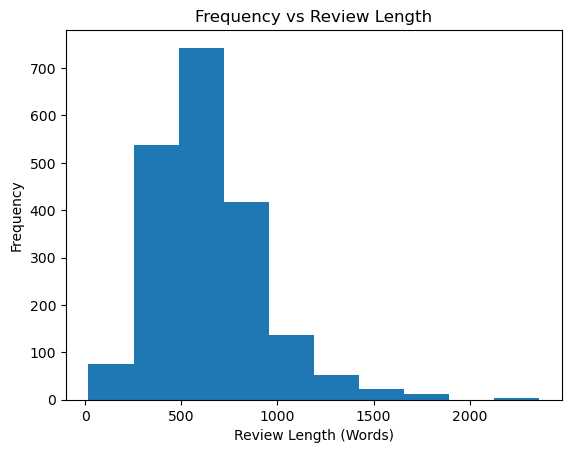

In [11]:
plt.hist(review_lengths)
plt.title('Frequency vs Review Length')
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.show()

Tokenize the words in the dataset by frequency (e.g. most common word in the text will be represented as 1, the second most common word will be
represented as 2, etc).

In [12]:
reviews = tokenizer.texts_to_sequences(reviews)

- View words and their assigned indices.

In [13]:
display(pd.DataFrame(tokenizer.word_index.items(), columns=['Word', 'Index']))

,Word,Index
0,the,1
1,a,2
2,and,3
3,of,4
4,to,5
...,...,...
46825,stonily,46826
46826,jokea,46827
46827,jerrymaguirewill,46828
46828,jerrymaguire,46829


- View tokenized data.

In [14]:
display(Markdown(f'{reviews[0]}'))

[67, 29, 355, 1633, 32, 90, 1046, 4, 627, 628, 321, 40, 704, 1755, 47, 1328, 396, 47, 1, 1777, 1778, 148, 16, 140, 108, 89, 68, 2, 355, 405, 39, 29, 502, 142, 12, 9, 31, 853, 21, 1352, 1802, 3, 944, 1511, 28, 878, 1, 5, 2, 282, 113, 540, 7, 1, 127, 11, 2, 202, 262, 381, 1, 5, 179, 1802, 3, 1511, 1881, 1, 845, 4, 495, 1, 69, 22, 39, 820, 324, 1231, 6, 2140, 5, 175, 2, 94, 1232, 1, 405, 47, 1548, 523, 51, 35, 65, 6, 111, 196, 3, 1233, 440, 42, 8, 4, 181, 16, 7, 73, 637, 119, 14, 15, 84, 4, 23, 2109, 51, 35, 64, 74, 403, 1, 282, 355, 405, 180, 35, 228, 188, 124, 7, 29, 879, 3, 1029, 333, 1, 620, 5, 1966, 14, 136, 178, 10, 10, 1089, 466, 7, 83, 232, 16, 103, 14, 28, 153, 5, 1966, 2, 15, 185, 259, 7, 1, 3, 629, 89, 995, 1047, 690, 58, 1, 1608, 384, 1261, 1020, 911, 1, 7, 486, 6, 4, 218, 7, 133, 23, 2, 235, 96, 1, 381, 20, 2140, 5, 74, 2, 94, 40, 14, 1147, 28, 33, 68, 121, 45, 11, 43, 1, 80, 336, 46, 524, 1, 148, 6, 25, 154, 1329, 7, 1779, 5, 1, 318, 2, 33, 1061, 17, 364, 5, 11, 4, 3, 436, 7, 17, 24, 2141, 382, 1008, 1549, 179, 9, 163, 38, 3, 5, 1, 8, 56, 1, 555, 220, 18, 119, 172, 325, 612, 5, 22, 19, 495, 1, 38, 18, 501, 129, 55, 1, 125, 73, 58, 5, 179, 1802, 3, 1511, 32, 2, 1174, 3, 222, 40, 157, 1, 1675, 4, 1, 505, 3, 1, 1030, 17, 5, 7, 1, 355, 36, 119, 1, 1675, 4, 1, 16, 1912, 2338, 3, 76, 2, 61, 254, 4, 1526, 54, 1711, 29, 732, 308, 1, 78, 133, 23, 176, 5, 237, 1, 212, 1, 4, 1527, 30, 3, 84, 81, 37, 24, 104, 108, 22, 1941, 4, 118, 1803, 3, 29, 314, 90, 103, 1, 1048, 29, 1, 12, 394, 28, 1581, 135, 1, 137, 903, 2, 209, 119, 37, 86, 253, 43, 35, 82, 9, 144, 1140, 29, 1090, 23, 377, 432, 3, 154, 3, 23, 1330, 5, 82, 93, 70, 42, 9, 299, 39, 2, 885, 2196, 15, 58, 565, 4, 1, 1528, 192, 30, 245, 9, 136, 39, 1882, 1, 18, 526, 459, 300, 157, 1550, 3, 285, 90, 25, 68, 38, 59, 40, 16, 1988, 524, 119, 179, 2, 638, 1, 4, 2110, 3, 2339, 86, 1, 982, 117, 103, 4, 1, 1582, 1913, 7, 56, 151, 1, 448, 7, 1, 15, 7, 1823, 5, 8, 7, 1, 355, 654, 1883, 837, 1884, 7, 126, 460, 1529, 336, 1, 203, 55, 26, 1443, 235, 56, 1, 206, 7, 29, 502, 6, 815, 11, 1, 1676, 7, 2, 509, 158, 3, 2, 959, 1396, 467, 789, 3, 7, 123, 489, 481, 16, 1, 145, 655, 125, 6, 18, 1, 80, 63, 53, 34, 1481, 34, 506, 30, 24, 1396, 16, 9, 174, 459, 342, 106, 1, 15, 143, 6, 37, 61, 886, 12, 509, 1108, 3, 923, 1712]

Select a review length $L$ that 70% of the reviews have a length below it.

In [15]:
review_lengths = np.sort(review_lengths)
L_index = int(len(review_lengths) * 0.7) - 1 
L = review_lengths[L_index]
display(Markdown(f'$L = {L}$.')) 

$L = 737$.

Truncate reviews longer than $L$ words and zero-pad reviews shorter than $L$ so that all texts (i.e. data points) are of length $L$.

In [16]:
reviews = pad_sequences(reviews, maxlen=L, padding='post', truncating='post')  

# split processed data into train and test sets
X_train, X_test = reviews[:1400], reviews[1400:]

- View padded data.

In [17]:
display(Markdown(f'{reviews[0].tolist()}'))

[67, 29, 355, 1633, 32, 90, 1046, 4, 627, 628, 321, 40, 704, 1755, 47, 1328, 396, 47, 1, 1777, 1778, 148, 16, 140, 108, 89, 68, 2, 355, 405, 39, 29, 502, 142, 12, 9, 31, 853, 21, 1352, 1802, 3, 944, 1511, 28, 878, 1, 5, 2, 282, 113, 540, 7, 1, 127, 11, 2, 202, 262, 381, 1, 5, 179, 1802, 3, 1511, 1881, 1, 845, 4, 495, 1, 69, 22, 39, 820, 324, 1231, 6, 2140, 5, 175, 2, 94, 1232, 1, 405, 47, 1548, 523, 51, 35, 65, 6, 111, 196, 3, 1233, 440, 42, 8, 4, 181, 16, 7, 73, 637, 119, 14, 15, 84, 4, 23, 2109, 51, 35, 64, 74, 403, 1, 282, 355, 405, 180, 35, 228, 188, 124, 7, 29, 879, 3, 1029, 333, 1, 620, 5, 1966, 14, 136, 178, 10, 10, 1089, 466, 7, 83, 232, 16, 103, 14, 28, 153, 5, 1966, 2, 15, 185, 259, 7, 1, 3, 629, 89, 995, 1047, 690, 58, 1, 1608, 384, 1261, 1020, 911, 1, 7, 486, 6, 4, 218, 7, 133, 23, 2, 235, 96, 1, 381, 20, 2140, 5, 74, 2, 94, 40, 14, 1147, 28, 33, 68, 121, 45, 11, 43, 1, 80, 336, 46, 524, 1, 148, 6, 25, 154, 1329, 7, 1779, 5, 1, 318, 2, 33, 1061, 17, 364, 5, 11, 4, 3, 436, 7, 17, 24, 2141, 382, 1008, 1549, 179, 9, 163, 38, 3, 5, 1, 8, 56, 1, 555, 220, 18, 119, 172, 325, 612, 5, 22, 19, 495, 1, 38, 18, 501, 129, 55, 1, 125, 73, 58, 5, 179, 1802, 3, 1511, 32, 2, 1174, 3, 222, 40, 157, 1, 1675, 4, 1, 505, 3, 1, 1030, 17, 5, 7, 1, 355, 36, 119, 1, 1675, 4, 1, 16, 1912, 2338, 3, 76, 2, 61, 254, 4, 1526, 54, 1711, 29, 732, 308, 1, 78, 133, 23, 176, 5, 237, 1, 212, 1, 4, 1527, 30, 3, 84, 81, 37, 24, 104, 108, 22, 1941, 4, 118, 1803, 3, 29, 314, 90, 103, 1, 1048, 29, 1, 12, 394, 28, 1581, 135, 1, 137, 903, 2, 209, 119, 37, 86, 253, 43, 35, 82, 9, 144, 1140, 29, 1090, 23, 377, 432, 3, 154, 3, 23, 1330, 5, 82, 93, 70, 42, 9, 299, 39, 2, 885, 2196, 15, 58, 565, 4, 1, 1528, 192, 30, 245, 9, 136, 39, 1882, 1, 18, 526, 459, 300, 157, 1550, 3, 285, 90, 25, 68, 38, 59, 40, 16, 1988, 524, 119, 179, 2, 638, 1, 4, 2110, 3, 2339, 86, 1, 982, 117, 103, 4, 1, 1582, 1913, 7, 56, 151, 1, 448, 7, 1, 15, 7, 1823, 5, 8, 7, 1, 355, 654, 1883, 837, 1884, 7, 126, 460, 1529, 336, 1, 203, 55, 26, 1443, 235, 56, 1, 206, 7, 29, 502, 6, 815, 11, 1, 1676, 7, 2, 509, 158, 3, 2, 959, 1396, 467, 789, 3, 7, 123, 489, 481, 16, 1, 145, 655, 125, 6, 18, 1, 80, 63, 53, 34, 1481, 34, 506, 30, 24, 1396, 16, 9, 174, 459, 342, 106, 1, 15, 143, 6, 37, 61, 886, 12, 509, 1108, 3, 923, 1712, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [18]:
input_shape = X_train[0].shape
assert(input_shape == L)

### Word Embeddings

Word embedding is a term used for representation of words for text analysis, typically in the form of a real-valued vector that encodes the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning.

We would like to use a word embedding layer for this project. Assume that we are interested in the top 5,000 words. This means that in each integer sequence that represents each document, we set to zero those integers that represent words that are not among the top 5,000 words in the document. Choose the length of the embedding vector for each word to be 32. Hence, each document is represented as a 32 × $L$ matrix. Also, flatten the matric of each document to a vector.
- `input_dim` : Size of the vocabulary
- `output_dim` : Length of the vector for each word
- `input_length` : Maximum length of a sequence

In [19]:
"""
I read this article to understand how embedding layers work in Keras:
https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce
"""
embedding_layer = Embedding(input_dim=5000, output_dim=32);
flatten_layer = Flatten();

### Multi-Layer Perceptron

Train a MLP with three (dense) hidden layers each of which has 50 ReLUs and one output layer with a single sigmoid neuron. Use a dropout rate of 20% for the first layer and 50% for the other layers. Use ADAM optimizer and binary cross entropy loss (which is equivalent to having a softmax in the output). To avoid overfitting, just set the number of epochs as 2. Use a batch size of 10.

In [20]:
batch_size = 10
epochs = 2

model = Sequential()
model.add(Input(shape=input_shape))
model.add(embedding_layer)
model.add(flatten_layer)
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']);
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs);

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 737, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 23584)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │     1,179,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,344,401 (5.13 MB)

 Trainable params: 1,344,401 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5125 - loss: 0.7072
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5824 - loss: 0.6754


 Report the train and test accuracies of this model.

- Training accuracy.

In [21]:
train_accuracy = model.evaluate(X_train, y_train, verbose=1) 

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8822 - loss: 0.4717


- Test accuracy.

In [22]:
test_accuracy = model.evaluate(X_test, y_test, verbose=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6565 - loss: 0.6405


### One-Dimensional Convolutional Neural Network

After the embedding layer, insert a Conv1D layer. This convolutional layer has 32 feature maps , and each of the 32 kernels has size 3, i.e. reads embedded word representations 3 vector elements of the word embedding at a time. The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer. The rest of the network is the same as the neural network above.

In [23]:
model = Sequential()
model.add(Input(shape=input_shape))
model.add(embedding_layer)
model.add(Conv1D(filters=32, kernel_size=3))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(flatten_layer)
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']);
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs);

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 737, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 735, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 367, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │       587,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 755,505 (2.88 MB)

 Trainable params: 755,505 (2.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4951 - loss: 0.6991
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5894 - loss: 0.6532


Report the train and test accuracies of this model.

- Training accuracy.

In [24]:
train_accuracy = model.evaluate(X_train, y_train, verbose=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8476 - loss: 0.3139


- Test accuracy.

In [25]:
test_accuracy = model.evaluate(X_test, y_test, verbose=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7153 - loss: 0.4852


### Long Short-Term Memory Recurrent Neural Network

The structure of the LSTM we are going to use is shown in the following figure.

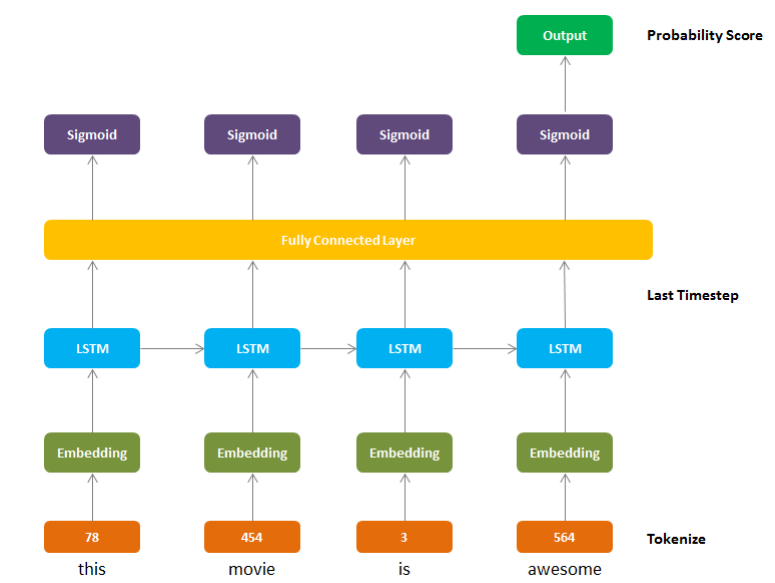

In [26]:
Image(filename='../img/LSTM.png', height=625, width=625)

Each word is represented to LSTM as a vector of 32 elements and the LSTM is followed by a dense layer of 256 ReLUs. Use a dropout rate of 0.2 for both LSTM and the dense layer. Train the model using 10-50 epochs and batch size of 10.

In [27]:
warnings.filterwarnings('ignore')

batch_size = 10
epochs = 10

# reshape train and test sets for LSTM layer
X_train = X_train.reshape(-1, 1, 737)
X_test = X_test.reshape(-1, 1, 737)
y_train = y_train.reshape(-1, 1, 1)
y_test = y_test.reshape(-1, 1, 1)

model = Sequential()
model.add(LSTM(units=32, activation='relu', input_shape=(1, 737))) 
model.add(Dropout(rate=0.2))
model.add(Dense(units=256, activation='relu')) 
model.add(Dropout(rate=0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy']);
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs);

ValueError: Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 737)

Report the train and test accuracies of this model.

- Training accuracy.

In [ ]:
train_accuracy = model.evaluate(X_train, y_train, verbose=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8305 - loss: 2.6756


- Test accuracy.

In [ ]:
test_accuracy = model.evaluate(X_test, y_test, verbose=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8123 - loss: 2.9931  
